# Optimal transport for Adaptation Domain

In domain adaptation, the optimal transport plan can be used to transfer knowledge from the source domain to the target domain by mapping the source domain's features to the target domain's features. This mapping ensures that similar features in the source and target domains are aligned, reducing the domain shift and improving the model's performance on the target domain.

In this tutorial we will see how to use the ott-jax library to perform domain adaptation. 

In [1]:
import sys

if "google.colab" in sys.modules:
    % pip install -q git+https: // github.com / ott-jax / ott @ main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 kB 3.7 MB/s eta 0:00:00


In [14]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import matplotlib.pyplot as plt

import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.problems.nn import dataset
from ott.solvers.linear import sinkhorn
from ott.solvers.nn import models, neuraldual

# Create the dataset

First, we generate a dataset consisting of 500 samples of 2-dimensional points, with two distinct classes, using the make_moons function from the sklearn.datasets module. The points in each class are arranged in the shape of a crescent moon. The target dataset will be the same moons but rotated of 40 degrees. 

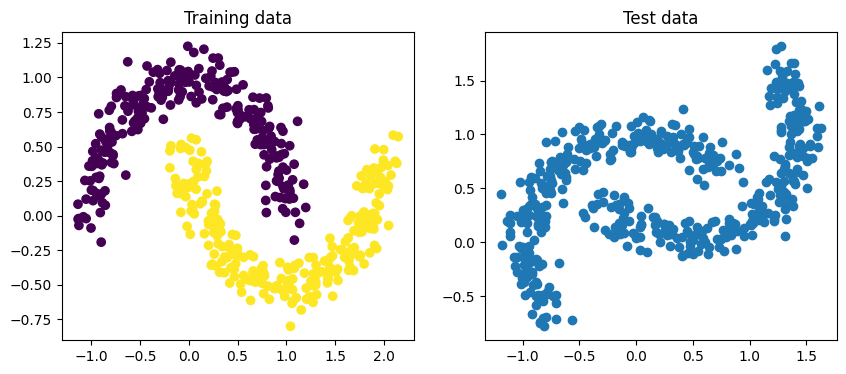

In [59]:
Xs, ys = make_moons(n_samples=500, noise=0.1, random_state=0)


def rotate_data(X, angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return np.dot(X, R.T)


Xt, yt = rotate_data(Xs, 40), ys

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(Xs[:, 0], Xs[:, 1], c=ys)
ax[0].set_title("Training data")
ax[1].scatter(Xt[:, 0], Xt[:, 1])
ax[1].set_title("Test data")
plt.show()

## Define the classification model

Here, we create an SVM classifier object using the SVC class from $scikit-learn$. We compute the accurary on both datasets. 



In [60]:
clf1 = SVC(kernel="rbf")
clf1.fit(Xs, ys)

acc_s = clf1.score(Xs, ys)
acc_t = clf1.score(Xt, yt)
print("Training accuracy:", acc_s)
print("Test accuracy:", acc_t)

Training accuracy: 0.998
Test accuracy: 0.676


In order to perform domain adaptation, we need to instantiate a OT problem with the point cloud we have. We solve it with sinkhorn and get the optimal transport plan $P$

In [61]:
# Create a point cloud
geom = pointcloud.PointCloud(Xs, Xt)
# Define a linear problem with that cost structure.
ot_prob = linear_problem.LinearProblem(geom)
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
# Solve OT problem
ot = solver(ot_prob)

# Retrieve the optimal transport plan
P = ot.to_dual_potentials()

Then, we have to apply the optimal transport plan $P$ to the set of points $Xs$. Specifically, the $transport$ method of the $P$ object takes a set of points as input and returns the corresponding set of points in the target domain.
 To apply this mapping to a specific set of points, we simply pass the set of points as an argument to the $transport$ method of the $P$ object.

In [62]:
Xs_t = P.transport(Xs)

We instanciate a new SVM that we fit over $X_s\__t$ and $y_s$.



In [63]:
clf2 = SVC(kernel="rbf")
clf2.fit(Xs_t, ys)

acc_s = clf2.score(Xs_t, ys)
acc_t = clf2.score(Xt, yt)
print("Training accuracy:", acc_s)
print("Test accuracy:", acc_t)

Training accuracy: 0.984
Test accuracy: 0.908


We thefore obtain better results.

# Using Neural Network Solver

In fact the problem we are tackling is a non-linear one. It would be better to use a non-linear method to solve it. To do so we again take the two moons dataset.

In [67]:
def get_two_moons_dataloader(
    train_size: int = 10000,
    test_size: int = 10000,
    noise: float = 0.05,
    batch_size: int = 100,
    rot=40,
):
    # Generate the two moons dataset
    X, y = make_moons(
        n_samples=train_size + test_size, noise=noise, random_state=42
    )

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    def rotate_data(X, angle):
        theta = np.radians(angle)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c, -s), (s, c)))
        return np.dot(X, R.T)

    X_test, y_test = rotate_data(X_test, rot), y_test

    # Split the train and test data into batches
    X_train_batches = [
        X_train[i : i + batch_size] for i in range(0, len(X_train), batch_size)
    ]
    y_train_batches = [
        y_train[i : i + batch_size] for i in range(0, len(y_train), batch_size)
    ]
    X_test_batches = [
        X_test[i : i + batch_size] for i in range(0, len(X_test), batch_size)
    ]
    y_test_batches = [
        y_test[i : i + batch_size] for i in range(0, len(y_test), batch_size)
    ]

    # Combine the inputs and labels into tuples
    train_data = iter(X_train_batches[:])
    test_data = iter(X_test_batches[:])

    return train_data, test_data

We need two generate two datasets.

In [68]:
train_dataloaders = dataset.Dataset(
    get_two_moons_dataloader()[0], get_two_moons_dataloader()[1]
)
valid_dataloaders = dataset.Dataset(
    get_two_moons_dataloader()[0], get_two_moons_dataloader()[1]
)

In [69]:
eval_data_source = next(valid_dataloaders.source_iter)
eval_data_target = next(valid_dataloaders.target_iter)

Next, we define the architectures parameterizing the dual potentials $f$ and $g$.

In [70]:
# initialize models and optimizers
num_train_iters = 100

neural_f = models.MLP(dim_hidden=[64, 64, 64, 64])
neural_g = models.MLP(
    dim_hidden=[64, 64, 64, 64],
    is_potential=False,  # returns the gradient of the potential.
)

lr_schedule = optax.cosine_decay_schedule(
    init_value=1e-4, decay_steps=num_train_iters, alpha=1e-2
)
optimizer_f = optax.adam(learning_rate=lr_schedule, b1=0.5, b2=0.5)
optimizer_g = optax.adam(learning_rate=lr_schedule, b1=0.9, b2=0.999)

## Training of the Neural Dual

In [71]:
input_dim = 2

neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=99,
)
learned_potentials = neural_dual_solver(
    *train_dataloaders,
    *valid_dataloaders,
)

  0%|          | 0/99 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>, <Axes: >)

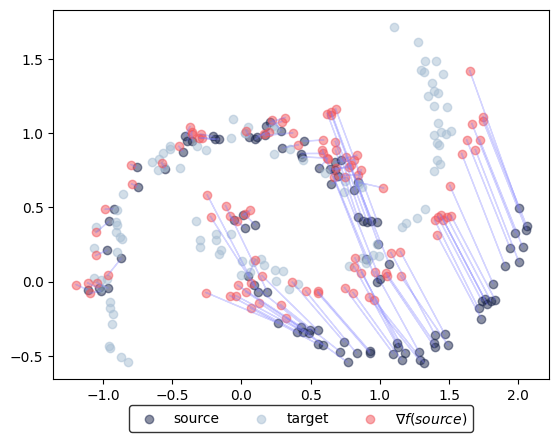

In [77]:
learned_potentials.plot_ot_map(eval_data_source, eval_data_target)

We next transport the $Xs$ over the distribution of $Xt$

In [73]:
pred = learned_potentials.transport(Xs)
clf = SVC(kernel="rbf")
clf.fit(pred, ys)

SVC()

We obtain far better accuracy than before.  

In [74]:
acc_s = clf.score(pred, ys)
acc_t = clf.score(Xt, yt)
print("Training accuracy:", acc_s)
print("Test accuracy:", acc_t)

Training accuracy: 0.988
Test accuracy: 0.992


Finally we can visualise the decision bourdary of our new classifier and the impact of the transportation of $X_s$ over $X_t$

In [75]:
def plot_decision_boundary(clf, X, y):
    h = 0.02  # step size in the meshgrid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    plt.show()

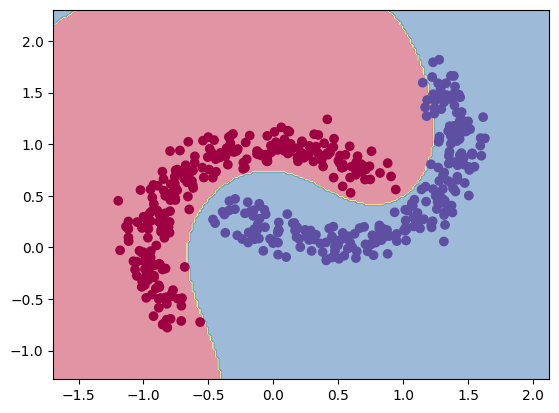

In [76]:
plot_decision_boundary(clf, Xt, yt)